In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, hub
from torchvision import models, transforms

In [2]:
class CustomResNet(models.ResNet):
    def __init__(self, num_classes=1000, pretrained=False, **kwargs):
        super().__init__(
            block=models.resnet.BasicBlock,
            layers=[2, 2, 2, 2],
            num_classes=num_classes,
            **kwargs
        )
        if pretrained:
            state_dict = hub.load_state_dict_from_url(
                models.resnet.model_urls["resnet18"], progress=True
            )
            self.load_state_dict(state_dict)

        # changes the original resnet architecture to not use fc layers
        self.avgpool = nn.AvgPool2d((7, 7))

        self.last_conv = nn.Conv2d(
            in_channels=self.fc.in_features, out_channels=num_classes, kernel_size=1
        )
        self.last_conv.weight.data.copy_(
            self.fc.weight.data.view(*self.fc.weight.data.shape, 1, 1)
        )
        self.last_conv.bias.data.copy_(self.fc.bias.data)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        # Uses conv layer instead of FC, which is used in the original ResNet
        x = self.last_conv(x)
        return x

model = CustomResNet(pretrained=True).eval()

In [3]:
with open("data/imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]
labels    

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

In [4]:
images = ["flamingo.jpg", "boat.jpeg", "camel.jpg", "pelican.jpg"]
IMAGE_NAME = f"images/{images[2]}"

(725, 1920, 3)


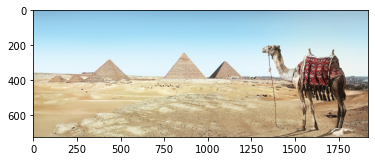

In [5]:
original_image = cv2.imread(IMAGE_NAME)
print(original_image.shape)
rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image);

In [6]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
image = transform(rgb_image)
print(image.shape)
image = image.unsqueeze(0)
print(image.shape)

torch.Size([3, 725, 1920])
torch.Size([1, 3, 725, 1920])


In [7]:
torch.set_grad_enabled(False);

In [8]:
predicates = model(image)
predicates.shape

torch.Size([1, 1000, 3, 8])

In [9]:
predicates = torch.softmax(predicates, dim=1)
pred, class_idx = torch.max(predicates, dim=1)
pred, class_idx

(tensor([[[0.0504, 0.0367, 0.0363, 0.0301, 0.0279, 0.0308, 0.0315, 0.0194],
          [0.5009, 0.1651, 0.1160, 0.1325, 0.1595, 0.0644, 0.8649, 0.3174],
          [0.0865, 0.1163, 0.0776, 0.2685, 0.1002, 0.1090, 0.2632, 0.7213]]]),
 tensor([[[977, 977, 977, 977, 977, 978, 354, 437],
          [978, 977, 980, 977, 858, 970, 354, 461],
          [977, 978, 977, 977, 977, 977, 354, 354]]]))

In [10]:
row_max, row_idx = torch.max(pred, dim=1)
col_max, col_idx = torch.max(row_max, dim=1)
predicted_class = class_idx[0, row_idx[0, col_idx], col_idx]

print(predicted_class)
print("Predicted Class : ", labels[predicted_class], predicted_class)

tensor([354])
Predicted Class :  Arabian camel, dromedary, Camelus dromedarius tensor([354])


In [11]:
score_map = predicates[0, predicted_class, :, :].cpu().numpy()
score_map = score_map[0]
score_map

array([[0.0047371 , 0.00392609, 0.00314854, 0.00374632, 0.00361893,
        0.00811971, 0.03148215, 0.01058931],
       [0.00205652, 0.09440026, 0.08510023, 0.03686867, 0.00627887,
        0.04773772, 0.8648716 , 0.00177067],
       [0.00419728, 0.00756088, 0.00457514, 0.0064999 , 0.00657837,
        0.00486964, 0.26315755, 0.7212609 ]], dtype=float32)

In [12]:
score_map = cv2.resize(
    score_map, (original_image.shape[1], original_image.shape[0])
)
print(original_image.shape)
print(score_map.shape)

(725, 1920, 3)
(725, 1920)


In [13]:
_, score_map_for_contours = cv2.threshold(
    score_map, 0.25, 1, type=cv2.THRESH_BINARY
)
score_map_for_contours = score_map_for_contours.astype(np.uint8).copy()

In [14]:
contours, _ = cv2.findContours(
    score_map_for_contours,
    mode=cv2.RETR_EXTERNAL,
    method=cv2.CHAIN_APPROX_SIMPLE,
)

In [15]:
rect = cv2.boundingRect(contours[0])

In [16]:
score_map = score_map - np.min(score_map[:])
score_map = score_map / np.max(score_map[:])
score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2BGR)
masked_image = (rgb_image * score_map).astype(np.uint8)

In [17]:
cv2.rectangle(
    masked_image,
    rect[:2],
    (rect[0] + rect[2], rect[1] + rect[3]),
    (0, 0, 255),
    2,
);

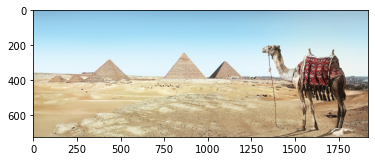

In [18]:
plt.imshow(rgb_image);

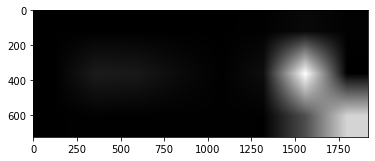

In [19]:
plt.imshow(score_map);

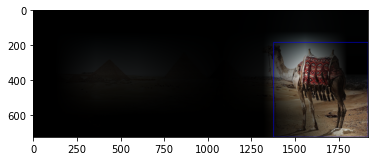

In [20]:
plt.imshow(masked_image);